# Predicting Churn
#### Braeden Wright - March 14, 2022

## Project Goal

The ultimate objective is to determine the main drivers behind churn for our customers, and then to build a model that will predict future customer churn in an effort to prevent the that future churn.

## Project Description

With the implimentaion of 5G networks across the country and the recent increase of people working from home, it is important now more than ever that we provide satisfation to our customers to retain their business. Here we will analyze our current customer base (with a focus on those whose churned) and determine what were some of the key factors in their depature from Telco. Furthermore we can find out how likely those factors were to contribute to a customer churning, thus giving us an idea of what measure we can take to keep those at risk customers from churning.

## Initial Questions

    - What customers are most important to prevent churning?

    - How long are customers that churn staying with us? What's their lifetime charges (total charges)? How do their total charges differ from those that did not churn?

    - What were the services that those higher value accounts looked for, and do they differ from their lower value counterparts?

    - These will more than likely be good indicators for churn

    - Will the customers household be a good indicator of churn? (Married, senior, children)

## Data Dictionary

#### Features
- churn	
- tenure 	
- monthly_charges 	
- total_charges 	
- is_male 	
- married 
- senior_citizen
- children 	
- phone_service 	
- multiple_lines 	
- online_security 	
- online_backup 	
- device_protection 	
- tech_support 	
- streaming_tv 	
- streaming_movies 	
- paperless_billing 
- one_year_contract
- two_year_contract 	
- fiber_optic 
- no_internet 
- card_auto_pay 
- electronic_check 
- mailed_check

#### Dataframes
- df = The main dataframe we will work with
- telco_df = An unprepped copy of the original dataframe 
- df_customer_id = A prepped copy of the original df, used to create our prediction CSV
- train = A sample of df, used to practice on different models
- validate = A sample of df, used to verify on different models
- test = A sample of df, ONLY USED ON BEST FITTING MODEL
- bottom_70 = a sample of those customers that churned, representing the bottom half of total charges in said sample
- top_30 = a sample of those customers that churned, representing the top half of total charges in said sample



# Imports Used

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

   # used to aquire dataset
import acquire_telco as aq
   # used to prepare and clean the dataset
import prepare_telco as pp

   # make sure we can see the full scale of the data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Alpha for statistical testing
α = .05

# Data Aquistion

In [2]:
# The function get_telco_data() I created in the file acquire.py pulls the dataset straight from SQL
# UNLESS the data has already been downloaded as a .csv,
# in which case the function will pull the data straight from that file instead.

df = aq.get_telco_data()
df.info()

Reading from csv file...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-nul

# Data Preperation

In [3]:
# The function prep_telco() that I created in the file prepare.py takes in the Telco dataframe and cleans it
# It does this by dropping uneeded columns ['payment_type_id', 'internet_service_type_id', 'contract_type_id']
# I also made sure the function cleared any nulls from the dataset
# Lastly, I make it easier to manipulate the data by creating dummy column for each categorical column.

In [4]:
# A copy of the original dataframe that did not go through the prep_telco
telco_df = df
# Copy of our dataframe that we prepare with prepare.py
df = pp.prep_telco(df)
df.head(2)

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,online_security_No internet service,online_security_Yes,online_backup_No internet service,online_backup_Yes,device_protection_No internet service,device_protection_Yes,tech_support_No internet service,tech_support_Yes,streaming_tv_No internet service,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,0002-ORFBO,0,9,65.6,593.3,0,1,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1
1,0003-MKNFE,0,9,59.9,542.4,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [5]:
# check for null values
df.isna().sum()

customer_id                              0
senior_citizen                           0
tenure                                   0
monthly_charges                          0
total_charges                            0
gender_Male                              0
partner_Yes                              0
dependents_Yes                           0
phone_service_Yes                        0
multiple_lines_No phone service          0
multiple_lines_Yes                       0
online_security_No internet service      0
online_security_Yes                      0
online_backup_No internet service        0
online_backup_Yes                        0
device_protection_No internet service    0
device_protection_Yes                    0
tech_support_No internet service         0
tech_support_Yes                         0
streaming_tv_No internet service         0
streaming_tv_Yes                         0
streaming_movies_No internet service     0
streaming_movies_Yes                     0
paperless_b

In [6]:
# rename columns for readability

df.rename(columns={'gender_Male': 'is_male',
                   'partner_Yes': 'married',
                   'dependents_Yes': 'children',
                   'phone_service_Yes': 'phone_service',
                   'multiple_lines_No phone service': 'no_phone_multiple_lines',
                   'multiple_lines_Yes': 'multiple_lines',
                   'online_security_No internet service': 'no_internet_online_security',
                   'online_security_Yes': 'online_security',
                   'online_backup_No internet service': 'no_internet_online_backup',
                   'online_backup_Yes': 'online_backup',
                   'device_protection_No internet service': 'no_internet_device_protection',
                   'device_protection_Yes': 'device_protection',
                   'tech_support_No internet service': 'no_internet_tech_support',
                   'tech_support_Yes': 'tech_support',
                   'streaming_tv_No internet service': 'no_internet_streaming_tv',
                   'streaming_tv_Yes': 'streaming_tv',
                   'streaming_movies_No internet service': 'no_internet_streaming_movies',
                   'streaming_movies_Yes': 'streaming_movies',
                   'paperless_billing_Yes': 'paperless_billing',
                   'churn_Yes': 'churn',
                   'contract_type_One year': 'one_year_contract',
                   'contract_type_Two year': 'two_year_contract',
                   'internet_service_type_Fiber optic': 'fiber_optic',
                   'internet_service_type_None': 'no_internet',
                   'payment_type_Credit card (automatic)': 'card_auto_pay',
                   'payment_type_Electronic check': 'electronic_check',
                   'payment_type_Mailed check': 'mailed_check'}, inplace=True)

# also drop customer id for training purposes
df_customer_id = df
df = df.drop(columns=['customer_id'])

In [7]:
# check the sum of each column to see if there is any redundancy
# doing so shows that several columns made for the dummy list can be represented by just 1 column
# the 'no_internet' column
df = df.drop(columns=['no_internet_streaming_movies',
                      'no_internet_streaming_tv',
                      'no_internet_tech_support',
                      'no_internet_device_protection', 
                      'no_internet_online_backup',
                      'no_internet_online_security',
                      'no_phone_multiple_lines'])

df.head(3)
# now we can move forward to exploring the data with visuals and statistics

,senior_citizen,tenure,monthly_charges,total_charges,is_male,married,children,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,churn,one_year_contract,two_year_contract,fiber_optic,no_internet,card_auto_pay,electronic_check,mailed_check
0,0,9,65.6,593.30,0,1,1,1,0,0,1,0,1,1,0,1,0,1,0,0,0,0,0,1
1,0,9,59.9,542.40,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,4,73.9,280.85,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0


# Exploratory Data Analysis and Statistical Testing

In [8]:
df.churn.value_counts()

0    5163
1    1869
Name: churn, dtype: int64

In [9]:
# details on 
telco_df.contract_type.value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: contract_type, dtype: int64

In [10]:
# details on tenure
telco_df.tenure.describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

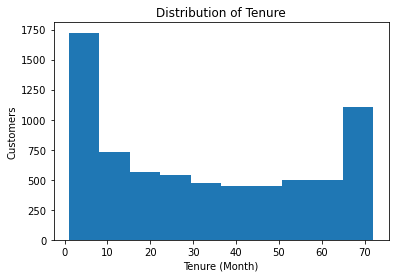

In [11]:
# distribution of tenure
plt.title('Distribution of Tenure')
plt.hist(x='tenure', data=df)
plt.xlabel('Tenure (Month)')
plt.ylabel('Customers')
plt.show()

In [12]:
# Two peaks, indicating two possible populations to explore
# Not a normal distribution


df.describe()
# This will give a few metrics to measure with when doing statistical exploration

,senior_citizen,tenure,monthly_charges,total_charges,is_male,married,children,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,churn,one_year_contract,two_year_contract,fiber_optic,no_internet,card_auto_pay,electronic_check,mailed_check
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441,0.504693,0.482509,0.298493,0.903299,0.421928,0.286547,0.344852,0.343857,0.290102,0.384386,0.388367,0.592719,0.265785,0.209329,0.239619,0.440273,0.216155,0.216297,0.336320,0.228100
std,0.368844,24.545260,30.085974,2266.771362,0.500014,0.499729,0.457629,0.295571,0.493902,0.452180,0.475354,0.475028,0.453842,0.486484,0.487414,0.491363,0.441782,0.406858,0.426881,0.496455,0.411650,0.411748,0.472483,0.419637
min,0.000000,1.000000,18.250000,18.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.000000,35.587500,401.450000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,55.000000,89.862500,3794.737500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
# Explore the distribution of Total Charges
df.total_charges.describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: total_charges, dtype: float64

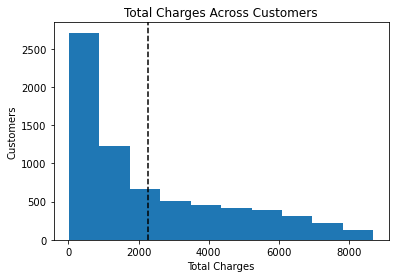

In [14]:
plt.title('Total Charges Across Customers')
plt.hist(x='total_charges', data=df)
plt.xlabel('Total Charges')
plt.ylabel('Customers')
plt.axvline(x=df['total_charges'].mean(), color='k', linestyle='dashed')
plt.show()

# Question 1 
#### What customers are most important to prevent churning?
- How long are customers that churn staying with us?
- What's their lifetime charges (total charges)?
- How do their total charges differ from those that did not churn?

In [15]:
# Let's take a closer look at accounts that churned to look for possible variables
churned_df = df[df.churn == 1]
no_churn_df = df[df.churn != 1]

# Verify changes and examine the distribution of total charges over tenure
churned_df.total_charges.describe()

count    1869.000000
mean     1531.796094
std      1890.822994
min        18.850000
25%       134.500000
50%       703.550000
75%      2331.300000
max      8684.800000
Name: total_charges, dtype: float64

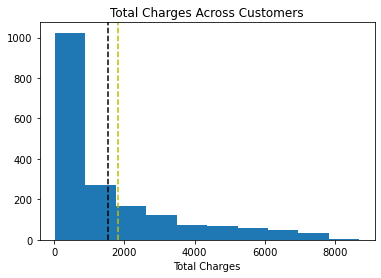

In [16]:
# Vizualize the distribution
plt.title('Total Charges Across Customers')
plt.hist(x='total_charges', data=churned_df)
plt.xlabel('Total Charges')
plt.axvline(x=churned_df['total_charges'].mean(), color='k', linestyle='dashed')
plt.axvline(x=churned_df['total_charges'].quantile(0.7), color='y', linestyle='dashed')
plt.show()

In [17]:
# There is a clear skew to the data, with the mean leaning heavily on the left of the graph
# Almost 70% of customers churned before reaching a lifetime value(LTV) of $1,800
churned_df.total_charges.quantile(0.7)

1800.9199999999983

- This seems like significant data from a business perspective, so we're going to invesigate further by seperating the bottom 70% of those who churned with the top 30% (with regards to total charges)

In [18]:
# Division of those churned accounts
bottom_70 = churned_df[churned_df.total_charges <= 1800.92]
top_30 = churned_df[churned_df.total_charges > 1800.92]

# Check distribution of the bottom 70%
bottom_70.total_charges.describe()

count    1308.000000
mean      481.136506
std       487.196050
min        18.850000
25%        78.762500
50%       271.550000
75%       810.325000
max      1789.250000
Name: total_charges, dtype: float64

In [19]:
# The lifetime value of these customers are low, averaging at just under $500
# How long did these accounts tenure with us?
bottom_70.tenure.describe()

count    1308.000000
mean        7.185015
std         7.894253
min         1.000000
25%         1.000000
50%         4.000000
75%        11.000000
max        61.000000
Name: tenure, dtype: float64

- The average tenure of these accounts is 7 months, a short time to be with Telco

In [20]:
# Show the distribution of LTV for the top 30% of customers that churned.
top_30.total_charges.describe()

count     561.000000
mean     3981.462299
std      1667.921308
min      1808.700000
25%      2550.900000
50%      3520.750000
75%      5224.350000
max      8684.800000
Name: total_charges, dtype: float64

In [21]:
# The value of these accounts are much higher, with an average LTV of almost $4,000 (8x as much as the lower 70%)
# Logically their tenure will be longer as well
top_30.tenure.describe()

count    561.000000
mean      43.146168
std       14.844432
min       18.000000
25%       31.000000
50%       41.000000
75%       55.000000
max       72.000000
Name: tenure, dtype: float64

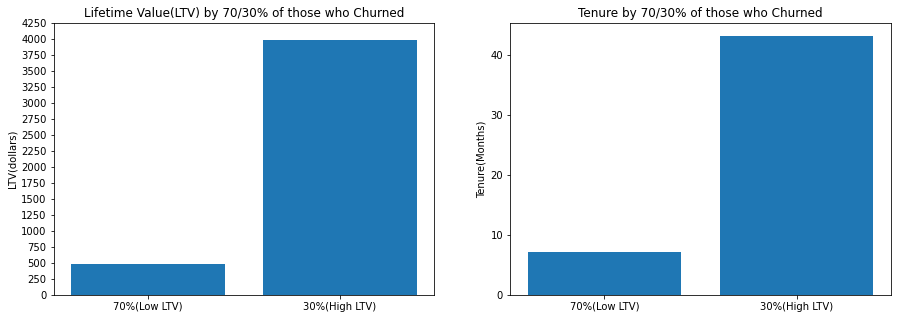

In [22]:
bot_charges = bottom_70.total_charges.mean()
top_charges = top_30.total_charges.mean()
bot_tenure = bottom_70.tenure.mean()
top_tenure = top_30.tenure.mean()

# Vizualize these side by side
plt.figure(figsize=[15, 5])
# Left Plot visualizes value of each population
plt.subplot(1, 2, 1)
plt.bar([1, 2], [bot_charges, top_charges])
plt.yticks(range(0,4500,250))
plt.xticks([1, 2] ,['70%(Low LTV)', '30%(High LTV)'])
plt.ylabel('LTV(dollars)')
plt.title('Lifetime Value(LTV) by 70/30% of those who Churned')


# Right Plot v
plt.subplot(1, 2, 2)
plt.bar([1, 2], [bot_tenure, top_tenure])
plt.xticks([1, 2], ['70%(Low LTV)', '30%(High LTV)'])
plt.ylabel('Tenure(Months)')
plt.title('Tenure by 70/30% of those who Churned')

plt.show()

- The graph shows the difference in average lifetime value between these two populations, where 70% of those who churn only averaged 500 dollars during their entie tenure with Telco, which itself averaged at 7 months.  Respectively, the top 30% of churned accounts average just under 4,000 dollars during their tenure, which averaged at 43 months.  Considering the majority contribution to revenue from the top 30%, I would suggest we focus on finding the key driver for churn from the bottom 70% in an effort to keep those accounts longer and move them to the High LTV category. 

# Question 2 - Deeper Look
#### What were the services that those higher value accounts looked for, and do they differ from their lower value counterparts?
- These will more than likely be good indicators for churn

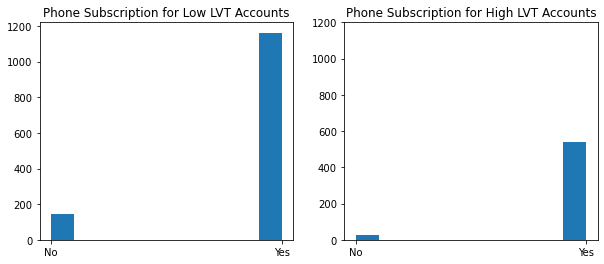

In [23]:
# First, lets compare phone service.

plt.figure(figsize=[10, 4])
# Left Plot visualizes value of each population
plt.subplot(1, 2, 1)
plt.hist(bottom_70.phone_service, rwidth=2)
plt.xticks([0, 1], ['No', 'Yes'])
plt.yticks(range(0,1300,200))
plt.title('Phone Subscription for Low LVT Accounts')

plt.subplot(1, 2, 2)
plt.hist(top_30.phone_service)
plt.xticks([0, 1], ['No', 'Yes'])
plt.yticks(range(0,1300,200))
plt.title('Phone Subscription for High LVT Accounts')


plt.show()

In [24]:
bot = (bottom_70.multiple_lines.sum()/bottom_70.phone_service.sum())
top = (top_30.multiple_lines.sum()/top_30.phone_service.sum())

print(f'Low LTV (70% of Churned Accounts): {bot:.2%}')
print(f'Hight LTV (30% of Churned Accounts): {top:.2%}')

Low LTV (70% of Churned Accounts): 37.95%
Hight LTV (30% of Churned Accounts): 76.16%


- Looking at the percentage of phone users that have multiple lines in both High and Low LTV, there is a notable difference.  The portion of Low LTV phone users with multiple lines is 37.95%.  Compared to double that for the High LTV population, at 76.16%


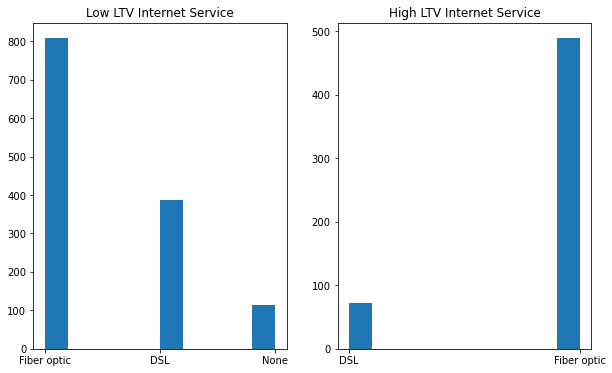

In [25]:
# First, I need to set up some variables
# This gives me the same data, but better fitted to graph the next few categories
telco_df.total_charges = telco_df.total_charges.replace(' ', 0).astype(float)
telco_df = telco_df[telco_df.tenure != 0]
churned_df = telco_df[telco_df.churn == 'Yes']
bottom_70_2 = churned_df[churned_df.total_charges <= 1800.92]
top_30_2 = churned_df[churned_df.total_charges > 1800.92]



# Now lets look at internet statistics, starting with service type
plt.figure(figsize = [10, 6])

plt.subplot(1, 2, 1)
plt.hist(bottom_70_2.internet_service_type)
plt.title('Low LTV Internet Service')

plt.subplot(1, 2, 2)
plt.hist(top_30_2.internet_service_type)
plt.title('High LTV Internet Service')

plt.show()

In [26]:
# What internet features attracted those high value customers?


# Low LTV 
total_internet_bot = bottom_70_2[bottom_70_2.internet_service_type != 'None'].internet_service_type.count()

results =[]

os = (bottom_70['online_security'].sum()/total_internet_bot)*100
ob = (bottom_70['online_backup'].sum()/total_internet_bot)*100
dp = (bottom_70['device_protection'].sum()/total_internet_bot)*100
ts = (bottom_70['tech_support'].sum()/total_internet_bot)*100
stv = (bottom_70['streaming_tv'].sum()/total_internet_bot)*100
sm = (bottom_70['streaming_movies'].sum()/total_internet_bot)*100
    
data ={
    'sample': 'Low LTV',
    'online_security': round(os, 2),
    'online_backup': round(ob, 2),
    'device_protection': round(dp, 2),
    'tech_support': round(ts, 2),
    'streaming_tv': round(stv, 2),
    'streaming_movies': round(sm, 2)
}

results.append(data)

# High LTV
total_internet_top = top_30_2[top_30_2.internet_service_type != 'None'].internet_service_type.count()


os = (top_30['online_security'].sum()/total_internet_top)*100
ob = (top_30['online_backup'].sum()/total_internet_top)*100
dp = (top_30['device_protection'].sum()/total_internet_top)*100
ts = (top_30['tech_support'].sum()/total_internet_top)*100
stv = (top_30['streaming_tv'].sum()/total_internet_top)*100
sm = (top_30['streaming_movies'].sum()/total_internet_top)*100
    
data ={
    'sample': 'High LTV',
    'online_security': round(os, 2),
    'online_backup': round(ob, 2),
    'device_protection': round(dp, 2),
    'tech_support': round(ts, 2),
    'streaming_tv': round(stv, 2),
    'streaming_movies': round(sm, 2)
}

results.append(data)

temp_df = pd.DataFrame(results)
temp_df.transpose()

,0,1
sample,Low LTV,High LTV
online_security,12.3,26.38
online_backup,19.67,51.34
device_protection,21.59,51.16
tech_support,12.47,28.7
streaming_tv,34.73,71.12
streaming_movies,34.73,71.84



# Question 3 - Household

- Will the customers household be a good indicator of churn?
- Let's also verify our other suspicions


In [27]:
# Lets start by seeing if married customers were more or less likely to churn

observed = pd.crosstab(df['married'], df['churn'])

chi2, p, degf, expected = stats.chi2_contingency(observed)

print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[2439 1200]
 [2724  669]]
---
Expected

[[2671.8084471  967.1915529]
 [2491.1915529  901.8084471]]
---

chi^2 = 157.5032
p     = 0.0000


In [44]:
# Children 
observed = pd.crosstab(df['children'], df['churn'])

chi2, p, degf, expected = stats.chi2_contingency(observed)

print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[3390 1543]
 [1773  326]]
---
Expected

[[3621.88267918 1311.11732082]
 [1541.11732082  557.88267918]]
---

chi^2 = 186.3216
p     = 0.0000


In [45]:
# Senior citizens
observed = pd.crosstab(df['senior_citizen'], df['churn'])

chi2, p, degf, expected = stats.chi2_contingency(observed)

print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[4497 1393]
 [ 666  476]]
---
Expected

[[4324.52645051 1565.47354949]
 [ 838.47354949  303.52645051]]
---

chi^2 = 158.4408
p     = 0.0000


- Because the p is less than .05, we can safely confirm that being married, a senior, or having children is at least a small indicator of someones risk to churn.  Or at least, these customers are less likely to churn.


### Takeaways Thus Far...

#### Our higher value customers that have a longer tenure with Telco are more likely to have the following features to their accounts:
- Multiple phone lines
- Almost certainly have internet
- More likely to have online security feature as well as device protection
- Much more likely to have streaming TV and Movies
- Those who churn are less likely to be married

# Modeling to fit the Data

In [28]:
# Time to start training our data to a model to predict churn
# Start by splitting the data into our train, validate, and test samples

train, test = train_test_split(df, 
                               train_size = 0.8,
                               random_state=1313)

train, validate = train_test_split(train,
                                  train_size = 0.7,
                                  random_state=1313)

train.shape, validate.shape, test.shape

((3937, 24), (1688, 24), (1407, 24))

In [29]:
# Variables for constructing models
x_train = train.drop(columns=['churn'])
y_train = train.churn

x_validate = validate.drop(columns=['churn'])
y_validate = validate.churn

x_test = test.drop(columns=['churn'])
y_test = test.churn

In [30]:
# A quick look if churn or no churn is more likely, to use as our baseline model.
train.churn.value_counts()

0    2892
1    1045
Name: churn, dtype: int64

In [31]:
# Now that our training sample is ready, lets set up a baseline accuracy to improve upon
train['baseline'] = 0

baseline_accuracy = (train.baseline == train.churn).mean()
print(f'Our baseline accuracy is {baseline_accuracy: .2%}')

Our baseline accuracy is  73.46%


## Model 1
- Logistic Regression
- Should allow me to choose what feature I think withh best fit the model

In [32]:
# Make the Model
logit = LogisticRegression(C=10, random_state=1313)

# Select the Features we want focused on
features = ['multiple_lines', 'device_protection', 'fiber_optic', 'married', 'streaming_tv']

# Fit the Model
logit.fit(x_train[features], y_train)

# Predictions
y_pred = logit.predict(x_train[features])

# Model Score
m_score = logit.score(x_train[features], y_train)

performance = classification_report(y_train, y_pred, output_dict=True)

# Classification Report
pd.DataFrame(performance).transpose()

,precision,recall,f1-score,support
0,0.787183,0.913209,0.845526,2892.00000
1,0.568729,0.316746,0.406884,1045.00000
accuracy,0.754890,0.754890,0.754890,0.75489
macro avg,0.677956,0.614978,0.626205,3937.00000
weighted avg,0.729199,0.754890,0.729097,3937.00000


- No I switched up features and other options for this model, but ultimately this model doesn't perform much better than the baseline model
- Accuracy sits at 75.5%, with precision of estimated churn hitting below 60%

## Model 2
- Random Forest
- Provides a good generalized model that 

In [33]:
# Make the Model
forest = RandomForestClassifier(max_depth=10, min_samples_leaf=5, random_state=1313)

# Fit the Model
forest.fit(x_train, y_train)

# Use the Model
y_pred = forest.predict(x_train)


performance = classification_report(y_train, y_pred, output_dict=True)

# Classification Report
pd.DataFrame(performance).transpose()

,precision,recall,f1-score,support
0,0.867324,0.942600,0.903397,2892.000000
1,0.790932,0.600957,0.682980,1045.000000
accuracy,0.851918,0.851918,0.851918,0.851918
macro avg,0.829128,0.771779,0.793188,3937.000000
weighted avg,0.847047,0.851918,0.844891,3937.000000


- I played around with the variables until I was able to determine what fit the model to the data best, without overfitting.
- Accuracy is 85% for Model 2 is fantastic, especialy considering our baseline accuracy of 73.5%.  Will need to verify that this is not over fitted to training sample.
- Precision is at 79% for predicting churn, with a recall of 60%.

 ## Model 3
 - KNN

In [34]:
# make the model
knn = KNeighborsClassifier(3)

# fit the model
knn = knn.fit(x_train, y_train)
    
# Use the model
y_pred = knn.predict(x_train)

#check the report
report = classification_report(y_train, y_pred, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0,0.884034,0.930498,0.906671,2892.000000
1,0.774916,0.662201,0.714138,1045.000000
accuracy,0.859284,0.859284,0.859284,0.859284
macro avg,0.829475,0.796349,0.810405,3937.000000
weighted avg,0.855071,0.859284,0.855567,3937.000000


- An accuracy of 86% for Model 3 shows promising results, especialy considering our baseline accuracy of 73.5%
- Precision is at 77.5% for predicting churn, with a recall of 66%.


# Model Evaluation

In [35]:
# Model 1 - Logistic Regression
# Examine the model using validate sample
# Make the Model
#logit = LogisticRegression(C=10, random_state=1313)

# Select the Features we want focused on
#features = ['multiple_lines', 'device_protection', 'fiber_optic', 'married', 'streaming_tv']

# Fit the Model
#logit.fit(x_validate[features], y_validate)

# Predictions
y_pred = logit.predict(x_validate[features])

# Model Score
m_score = logit.score(x_validate[features], y_validate)

performance = classification_report(y_validate, y_pred, output_dict=True)

# Classification Report
pd.DataFrame(performance).transpose()

,precision,recall,f1-score,support
0,0.790098,0.908581,0.845207,1247.000000
1,0.551181,0.317460,0.402878,441.000000
accuracy,0.754147,0.754147,0.754147,0.754147
macro avg,0.670639,0.613020,0.624042,1688.000000
weighted avg,0.727679,0.754147,0.729646,1688.000000


In [36]:
# Model 2 - Random Forest
# Examine the model using validate sample
# Make the Model
#forest = RandomForestClassifier(max_depth=10, min_samples_leaf=5, random_state=1313)

# Fit the Model
#forest.fit(x_train, y_train)

# Use the Model
y_pred = forest.predict(x_validate)


performance = classification_report(y_validate, y_pred, output_dict=True)

# Classification Report
pd.DataFrame(performance).transpose()

,precision,recall,f1-score,support
0,0.840386,0.907779,0.872783,1247.000000
1,0.662757,0.512472,0.578005,441.000000
accuracy,0.804502,0.804502,0.804502,0.804502
macro avg,0.751571,0.710125,0.725394,1688.000000
weighted avg,0.793979,0.804502,0.795771,1688.000000


Model 2 continues to hold as the stronger model
- Accuracy went from 85.4% down to 80.5% 
- Precision went from 79% down to 66.3%


Though I was worried about the Model being over fit for the training sample, its performance on the validate sample allow me to conclude it should be safe to use.  And unless Model 3 drastically improves on the next model, I feel Model 2 is going to be our best model to predict churn with.

In [37]:
# Model 3 - KNN
# Examine the model using validate sample
# make the model
#knn = KNeighborsClassifier(3)

# fit the model
#knn = knn.fit(x_train, y_train)
    
# Use the model
y_pred = knn.predict(x_validate)

#check the report
report = classification_report(y_validate, y_pred, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0,0.812117,0.849238,0.830263,1247.000000
1,0.510417,0.444444,0.475152,441.000000
accuracy,0.743483,0.743483,0.743483,0.743483
macro avg,0.661267,0.646841,0.652707,1688.000000
weighted avg,0.733296,0.743483,0.737488,1688.000000



- Compared to the training sample, Model 3 performs just as expected.
- Accuracy dropped from 86% to 74.3%
- Precision dropped drastically to 51%


## Model 2 clearly performs the best on Train and Validate, and should be the model to fit to our final Test Sample

In [38]:
# Model 2 - Random Forest
# Examine the model using validate sample
# Make the Model
#forest = RandomForestClassifier(max_depth=10, min_samples_leaf=5, random_state=1313)

# Fit the Model
#forest.fit(x_train, y_train)

# Use the Model
y_pred = forest.predict(x_test)
y_proba = forest.predict_proba(x_test)

performance = classification_report(y_test, y_pred, output_dict=True)

# Classification Report
pd.DataFrame(performance).transpose()

,precision,recall,f1-score,support
0,0.833037,0.916016,0.872558,1024.000000
1,0.693950,0.509138,0.587349,383.000000
accuracy,0.805259,0.805259,0.805259,0.805259
macro avg,0.763494,0.712577,0.729954,1407.000000
weighted avg,0.795176,0.805259,0.794921,1407.000000


- Continues to hold the best consistent accuracy at 80.5%, arguably the most important metric
- Precision of predicting churn sits at 69%

# Finding and Key Takeaways

In [39]:
# Make sure the Customer ID is available for our final predictions
train, test_id = train_test_split(df_customer_id, 
                               train_size = 0.8,
                               random_state=1313)

final_prediction = test_id.customer_id
final_prediction = pd.DataFrame(final_prediction)
final_prediction.head(2)

,customer_id
3546,5027-QPKTE
2605,3717-LNXKW
4157,5879-HMFFH
6521,9253-QXKBE
3994,5630-AHZIL


In [40]:
# Now lets add on our predictions and probabilities
final_prediction['Predict to Churn'] = y_pred
final_prediction['Probability of Churn'] = y_proba[0:1407, 1:1407]

- Using our Test Sample we can now produce a dataframe predicting the probability of any given account to churn!  And going of the graph, our model seems to deem an account likely to churn once it reaches a probability of about 50%

In [41]:
final_prediction

,customer_id,Predict to Churn,Probability of Churn
3546,5027-QPKTE,0,0.444449
2605,3717-LNXKW,0,0.291944
4157,5879-HMFFH,0,0.000638
6521,9253-QXKBE,1,0.563956
3994,5630-AHZIL,0,0.349321
3381,4815-YOSUK,0,0.185832
6565,9330-VOFSZ,0,0.094604
1714,2498-XLDZR,0,0.034688
1137,1670-SVOWZ,0,0.392735
4362,6152-ONASV,0,0.037402


In [42]:
final_prediction.describe()

,Predict to Churn,Probability of Churn
count,1407.000000,1407.000000
mean,0.199716,0.270150
std,0.399929,0.233186
min,0.000000,0.000250
25%,0.000000,0.067642
50%,0.000000,0.196587
75%,0.000000,0.445250
max,1.000000,0.914964


In [43]:
# Download Final_predictions to CSV
filename = 'final_predictions.csv'
final_prediction.to_csv(filename, index=False)

# Conclusion
- Looking at the features that were most popular for High LTV customers, we can accurately predict when a customer might churn.  Features that historically lead to a longer tenure and therefore less churn are:

        - Multiple Phone lines
        - Have internet,  particularly Fiber Optic
        - High LTV accounts enroll in Online Security and Device Protection
        - Any kind of streaming service
        - Married customers are also less likely to churn

    
- These features would almost all be good to prioritize when advertising to customers.  For example, if we have a customer without any streaming service, but has a shorter tenure (>7months) and that customer is also married, getting them enrolled in a streaming service would serve as a good way to reduce their risk of churn.
- Looking forward, I would suggest polling customers that churn to get, in their own words, what was the cause of their departure.

 - Code used to acquire and prepare the data, and additional work done by Braeden Wright can be found at https://github.com/BraedenWright/classification-project
 